# Feature Importance

## Imports

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Models & Normalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Evaluation
import statsmodels.api as sm

# Extra
from utils import *

## Open the Clean data

In [2]:
file_path = "Data/cleaned_house_sales.csv"

df_clean = pd.read_csv(file_path)
df_clean.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,month_sold,day_sold
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [3]:
# Same seed for all random states
seed = 13

# The price is the target variable
y = df_clean["price"]

# All other variables are the features for the baseline model
X = df_clean.drop("price", axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)


## Lasso (L1 regularization) 

Should reduce less important features to 0. Applying it to find features we can drop.

In [4]:
# standardization
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_standard = std_scaler.fit_transform(X_train)
X_test_standard = std_scaler.fit_transform(X_test)

In [5]:
print(X_train_standard.min(), X_train_standard.max())

-3.956684808851382 39.35388067380475


The max value being so extreme even after standardization points to a distribution with many outliers.

In [6]:
features = X_train.columns
features

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_sold', 'month_sold', 'day_sold'],
      dtype='str')

In [7]:
lasso_regressor = Lasso(random_state=seed)

lasso_regressor.fit(X_train_standard, y_train)

/Users/anne/Documents/_IronHack/Projects/King-County-Housing-Analysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e+13, tolerance: 2.354e+11
  model = cd_fast.enet_coordinate_descent(


,"alpha alpha: float, default=1.0Constant that multiplies the L1 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Lasso` object is not advised.Instead, you should use the :class:`LinearRegression` object.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"precompute precompute: bool or array-like of shape (n_features, n_features), default=FalseWhether to use a precomputed Gram matrix to speed upcalculations. The Gram matrix can also be passed as argument.For sparse input this option is always ``False`` to preserve sparsity.",False
,"copy_X copy_X: bool, default=TrueIf ``True``, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=1000The maximum number of iterations.",1000
,"tol tol: float, default=1e-4The tolerance for the optimization: if the updates are smaller or equal to``tol``, the optimization code checks the dual gap for optimality and continuesuntil it is smaller or equal to ``tol``, see Notes below.",0.0001
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fit asinitialization, otherwise, just erase the previous solution.See :term:`the Glossary `.",False
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.",False
,"random_state random_state: int, RandomState instance, default=NoneThe seed of the pseudo random number generator that selects a randomfeature to update. Used when ``selection`` == 'random'.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",13
,"selection selection: {'cyclic', 'random'}, default='cyclic'If set to 'random', a random coefficient is updated every iterationrather than looping over features sequentially by default. This(setting to 'random') often leads to significantly faster convergenceespecially when tol is higher than 1e-4.",'cyclic'


In [28]:
# Regression coefficients

coefs_lasso = pd.Series(np.abs(lasso_regressor.coef_), features).sort_values(ascending=False)

coefs_lasso

sqft_living      260890.945338
grade            113621.446101
lat               84316.523244
sqft_above        81991.026779
yr_built          76475.889246
sqft_basement     59472.818333
waterfront        49274.007710
view              39200.831428
bedrooms          33789.239856
long              32117.139742
bathrooms         32082.314821
zipcode           31555.515044
condition         17557.032206
year_sold         16266.798818
sqft_living15     14460.312554
sqft_lot15        10391.559985
yr_renovated       8500.402589
sqft_lot           4863.151159
day_sold           2879.776176
floors             2293.208022
month_sold         1979.637736
dtype: float64

<Axes: title={'center': 'Lasso Coefficients'}>

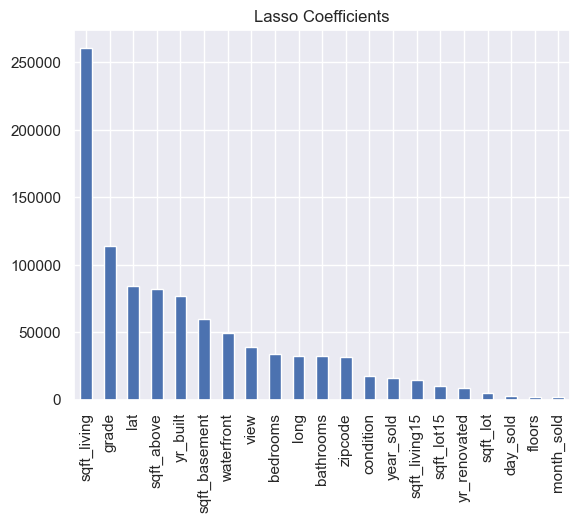

In [29]:
sns.set_theme()
coefs_lasso.plot(kind='bar', title='Lasso Coefficients')


The lasso regressor did not identify any irrelevant parameters that we could currently drop.

## Ridge (L2 regularization)


Reduces coefficients magnitudes for correlated features. Should give us an idea of multicollinearity.

In [30]:
ridge_regressor = Ridge(random_state=seed)
ridge_regressor.fit(X_train_standard, y_train)


# Regression coefficients

coefs_ridge = pd.Series(np.abs(ridge_regressor.coef_), features).sort_values(ascending=False)


<Axes: title={'center': 'Ridge Coefficients'}>

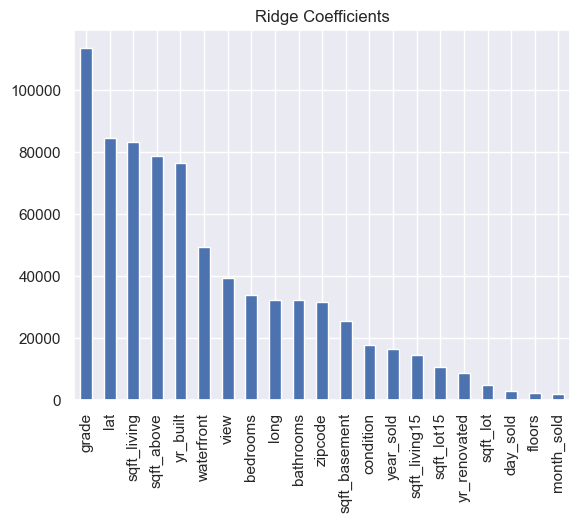

In [31]:
sns.set_theme()
coefs_ridge.plot(kind='bar', title='Ridge Coefficients')

### Lasso vs. Ridge

In [32]:
# combined

feature_importance = pd.DataFrame({"lasso": coefs_lasso, "ridge": coefs_ridge})

In [33]:
feature_importance = feature_importance.reset_index()
feature_importance

,index,lasso,ridge
0,bathrooms,32082.314821,32087.628497
1,bedrooms,33789.239856,33783.663620
2,condition,17557.032206,17559.541392
3,day_sold,2879.776176,2880.548680
4,floors,2293.208022,2295.681048
5,grade,113621.446101,113606.366537
6,lat,84316.523244,84314.151501
7,long,32117.139742,32118.058335
8,month_sold,1979.637736,1982.151021
9,sqft_above,81991.026779,78520.819072


In [34]:
import pandas as pd
import plotly.express as px

# Fix formating of the dataframe for plotting
df_melted = feature_importance.melt(id_vars='index', 
                     value_vars=['lasso', 'ridge'],
                     var_name='Model', 
                     value_name='Coefficient')

# Create a interactive bar plot
fig = px.bar(df_melted.sort_values("Coefficient", ascending=False), 
             x='index', 
             y='Coefficient', 
             color='Model',          
             barmode='group',        # side-by-side, not stacked
            color_discrete_map={
                 'lasso': '#4c72b0', 
                 'ridge': '#dd8452'},
             title='Feature Importance: Lasso vs Ridge')

# 3. Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Features',
    yaxis_title='Absolute Coefficient Value'
)

fig.show()


## XGBoost

In [35]:
import xgboost as xgb

xgb_clf = xgb.XGBRegressor(seed = seed)
xgb_clf.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [37]:
features = X_train.columns
coefs_xgb = pd.Series(np.abs(xgb_clf.feature_importances_), features).sort_values(ascending=False)

coefs_xgb


grade            0.368874
waterfront       0.170580
sqft_living      0.167270
lat              0.075877
long             0.041144
view             0.037144
sqft_living15    0.020389
yr_built         0.018146
zipcode          0.016965
bathrooms        0.012077
sqft_above       0.011518
year_sold        0.011033
condition        0.009306
yr_renovated     0.008090
sqft_lot         0.007944
sqft_basement    0.005541
sqft_lot15       0.005373
month_sold       0.004566
day_sold         0.003449
floors           0.003055
bedrooms         0.001659
dtype: float32

<Axes: title={'center': 'XGBoost Coefficients'}>

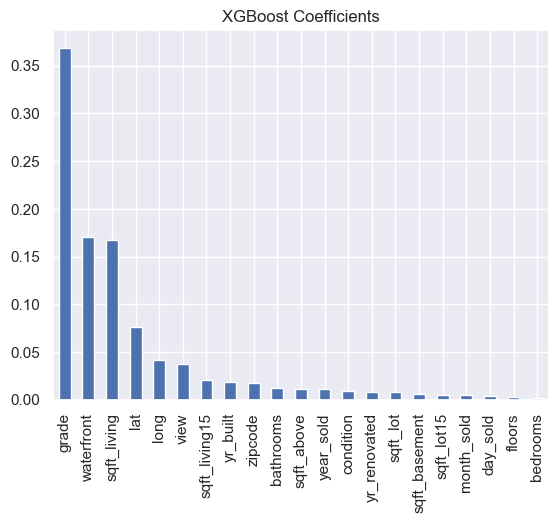

In [38]:
coefs_xgb.plot(kind='bar', title='XGBoost Coefficients')

## Random Forest

In [19]:
# most common hyperparameters or the default ones
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=seed)#default values + random_state = 13
rf_regressor.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [39]:
features = X_train.columns
coefs_rf = pd.Series(np.abs(rf_regressor.feature_importances_), features).sort_values(ascending=False)

coefs_rf


grade            0.313353
sqft_living      0.274236
lat              0.159146
long             0.069911
sqft_living15    0.030356
waterfront       0.025279
yr_built         0.023713
sqft_above       0.018558
zipcode          0.012953
sqft_lot         0.012211
view             0.011875
sqft_lot15       0.011449
bathrooms        0.007467
day_sold         0.006681
month_sold       0.006077
sqft_basement    0.005584
bedrooms         0.002960
condition        0.002917
yr_renovated     0.002241
floors           0.001909
year_sold        0.001126
dtype: float64

<Axes: title={'center': 'Random Forest Coefficients'}>

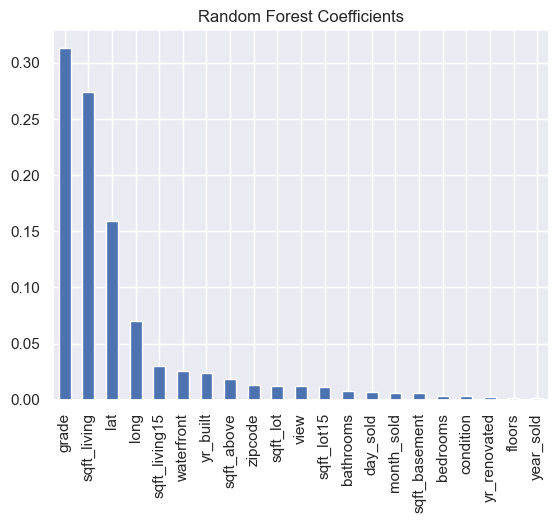

In [40]:
coefs_rf.plot(kind='bar', title='Random Forest Coefficients')

### Random Forest vs XGBoost

In [41]:
feature_importance = pd.DataFrame({"rf": coefs_rf, "xgb": coefs_xgb})
feature_importance = feature_importance.reset_index()
feature_importance

,index,rf,xgb
0,bathrooms,0.007467,0.012077
1,bedrooms,0.002960,0.001659
2,condition,0.002917,0.009306
3,day_sold,0.006681,0.003449
4,floors,0.001909,0.003055
5,grade,0.313353,0.368874
6,lat,0.159146,0.075877
7,long,0.069911,0.041144
8,month_sold,0.006077,0.004566
9,sqft_above,0.018558,0.011518


In [42]:
import pandas as pd
import plotly.express as px

# Fix formating of the dataframe for plotting
df_melted = feature_importance.melt(id_vars='index', 
                     value_vars=['rf', 'xgb'],
                     var_name='Model', 
                     value_name='Coefficient')

# Create a interactive bar plot
fig = px.bar(df_melted.sort_values("Coefficient", ascending=False), 
             x='index', 
             y='Coefficient', 
             color='Model',          
             barmode='group',        # side-by-side, not stacked
            color_discrete_map={
                 'rf': '#4c72b0', 
                 'xgb': '#dd8452'},
             title='Feature Importance: Random Forest vs XGBoost')

# 3. Rotate x-axis labels
fig.update_layout(
    xaxis_tickangle=-45,
    xaxis_title='Features',
    yaxis_title='Absolute Coefficient Value'
)

fig.show()
